# Evaluate Naturalness Survey

In [147]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns 
import matplotlib.pyplot as plt

In [148]:
df = pd.read_csv("Batch_4365949_batch_results_2.csv")

## Convert rating to numbers

In [149]:
label_to_num = {
    "Excellent - Completely natural speech" : 5,
    "Good - Mostly natural speech": 4,
    "Fair - Equally natural and unnatural speech": 3,
    "Poor - Mostly unnatural speech" : 2,
    "Bad - Completely unnatural speech" : 1
}

In [150]:
df_copy = df.copy()
# Select only values that werent rejected
df_copy = df_copy[df_copy["AssignmentStatus"] == "Submitted"]
df_copy["naturalness"] = df_copy["Answer.audio-naturalness.label"].apply(lambda x: label_to_num[x])

## Seperate our results from Face2Speech results

In [151]:
ours = df_copy[df_copy["Input.audio_url"].str.contains("bjoernpl/ThesisSurveyFiles/blob/main/ours/")]
theirs = df_copy[df_copy["Input.audio_url"].str.contains("DeNA/Face2Speech//blob/master/docs")]
both = pd.DataFrame({
    "ours" : ours["naturalness"].value_counts(),
    "theirs" : theirs["naturalness"].value_counts()
}).sort_index()
both

,ours,theirs
1,9,15
2,40,71
3,169,185
4,295,253
5,87,75


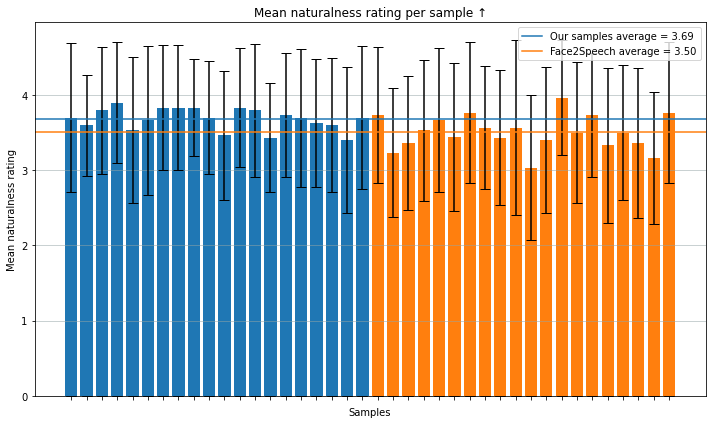

In [199]:
per_sample = ours.groupby("HITId")
ys = list(per_sample["naturalness"].mean().values) + [0.0]*20
yerrs = list(per_sample["naturalness"].std().values) + [0.0]*20
xs = np.arange(len(ys))
yts = [0.0]*20 + list(theirs.groupby("HITId")["naturalness"].mean().values)
yterrs = [0.0]*20 + list(theirs.groupby("HITId")["naturalness"].std().values)
fig = plt.figure(figsize=(10, 6))
width = 0.3
plt.grid(color='#95a5a6', linewidth=1, axis='y', alpha=0.5)
plt.bar(xs, ys, yerr=yerrs,capsize=5)
plt.bar(xs, yts,yerr=yterrs,capsize=5)
plt.axhline(np.mean(ys[:20]), label=f"Our samples average = {np.mean(ys[:20]):.2f}")
plt.axhline(np.mean(yts[20:]), color="tab:orange", label=f"Face2Speech average = {np.mean(yts[20:]):.2f}")
plt.legend()
plt.xticks(xs, labels = [""]*40)
plt.xlabel("Samples")
plt.ylabel("Mean naturalness rating")
plt.title("Mean naturalness rating per sample ↑")
plt.tight_layout()
plt.savefig("naturalness_per_sample_std.pdf")
plt.show()

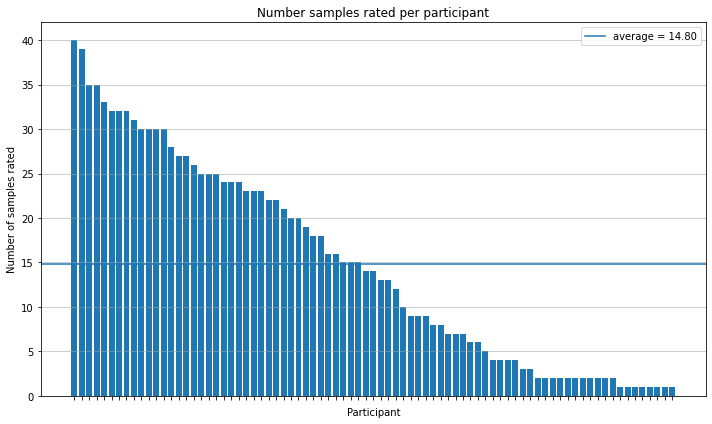

In [179]:
participants = df_copy.groupby("WorkerId")
ys = sorted(list(participants["naturalness"].count()), reverse=True)
xs = np.arange(len(ys))
fig = plt.figure(figsize=(10, 6))
plt.grid(color='#95a5a6', linewidth=1, axis='y', alpha=0.5)
plt.bar(xs, ys)
plt.axhline(np.mean(ys), label=f"average = {np.mean(ys):.2f}")
plt.legend()
plt.xticks(xs, labels = [""]*len(xs))
plt.xlabel("Participant")
plt.ylabel("Number of samples rated")
plt.title("Number samples rated per participant")
plt.tight_layout()
plt.show()

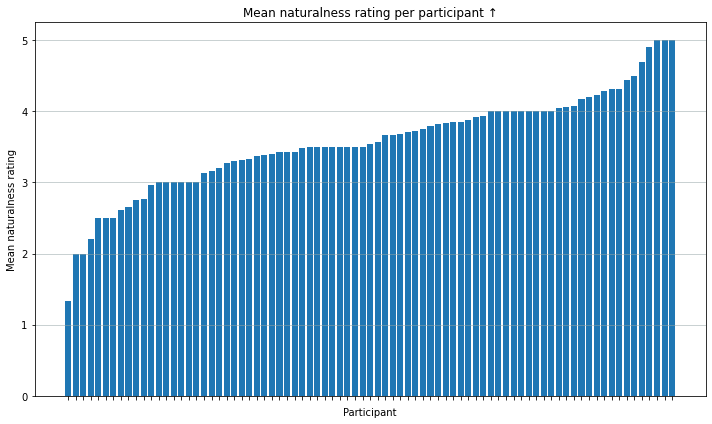

In [176]:
participants = df_copy.groupby("WorkerId")
ys = sorted(list(participants["naturalness"].mean().values))
xs = np.arange(len(ys))
fig = plt.figure(figsize=(10, 6))
plt.grid(color='#95a5a6', linewidth=1, axis='y', alpha=0.5)
plt.bar(xs, ys)
plt.xticks(xs, labels = [""]*len(xs))
plt.xlabel("Participant")
plt.ylabel("Mean naturalness rating")
plt.title("Mean naturalness rating per participant ↑")
plt.tight_layout()
plt.show()

## Calculate Mean and 95% 

In [155]:
m = ours["naturalness"].mean()
l,t = st.t.interval(alpha=0.95, df=len(ours)-1, loc=m, scale=st.sem(ours["naturalness"])) 

print(f"Mean naturalness rating: {float(m):.2f} +- {float(m-l):.2f}")

Mean naturalness rating: 3.69 +- 0.07


In [169]:
vals = ours.groupby("HITId")["naturalness"].mean().values
m = np.mean(vals)
variance = np.sum((vals-m)**2) / (len(vals)-1)
variance

0.020874269005847965

In [118]:
m = theirs["naturalness"].mean()
l,t = st.t.interval(alpha=0.95, df=len(theirs)-1, loc=m, scale=st.sem(theirs["naturalness"])) 

print(f"Mean naturalness rating: {float(m):.3f} +- {float(m-l):.2f}")

Mean naturalness rating: 3.504 +- 0.08


In [170]:
vals = theirs.groupby("HITId")["naturalness"].mean().values
m = np.mean(vals)
variance = np.sum((vals-m)**2) / (len(vals)-1)
variance

0.05193614883423383

## Check if participants only rating some samples had influence

600


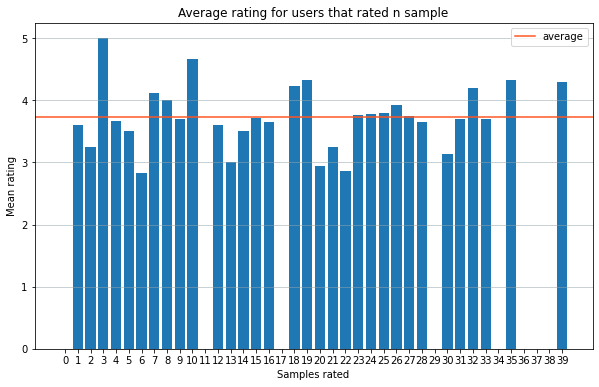

In [182]:
n_per_p = df_copy.groupby("WorkerId")
means = np.zeros(40, dtype=float)
lens = np.zeros(40, dtype=float)
print(len(ours))
for i in range(40):
    a = n_per_p["naturalness"].count()[n_per_p["naturalness"].count() == i]
    out = ours[ours["WorkerId"].isin(a.keys())]
    lens[i] = len(out["naturalness"])
    mean = out["naturalness"].mean()
    means[i] = mean if not np.isnan(mean) else 0
xs = list(range(40))
fig = plt.figure(figsize=(10, 6))
plt.grid(color='#95a5a6', linewidth=1, axis='y', alpha=0.5)
plt.bar(xs,[means[x] for x in xs])
plt.axhline(np.mean(means[means > 0]), color="#FF5522", label="average")
plt.legend()
plt.xticks(xs)
plt.xlabel("Samples rated")
plt.ylabel("Mean rating")
plt.title("Average rating for users that rated n sample")
plt.show()

### Average rating excluding speakers that rated less than n samples

In [185]:
# For Face2Speech
n_per_p = theirs.groupby("WorkerId")
n = 5
a = n_per_p["naturalness"].count()[n_per_p["naturalness"].count() > n]
out = theirs[theirs["WorkerId"].isin(a.keys())]
out["naturalness"].mean()

3.4944444444444445

In [186]:
# For Ours
n_per_p = ours.groupby("WorkerId")
n = 5
a = n_per_p["naturalness"].count()[n_per_p["naturalness"].count() > n]
out = ours[ours["WorkerId"].isin(a.keys())]
out["naturalness"].mean()

3.6907020872865277